# Summary of example

We'll create a family of `N_itp_samples` two-segment piecewise-linear functions via `createendopiewiselines1()`, fit the parameters of a logistic-logit function for each family member, and visualize its effect as a transport map.

The logistic-logit function has the following form.
$$
\begin{align*}
f\left(x\right) & :\left(0,1\right)\rightarrow\left(0,1\right)\\
x & \mapsto\frac{1}{1+\exp\left(-a\ln\left(\frac{x}{1-x}-b\right)\right)}.
\end{align*}
$$

# Dependencies for this example
The following installs the packages used in this example.
```julia
import Pkg
Pkg.add(path="https://github.com/RoyCCWang/IntervalMonoFuncs.jl")
Pkg.add("PyPlot")
Pkg.add("NLopt")
```

# The example guide
Load the packages for this example:

In [1]:
import IntervalMonoFuncs
using LinearAlgebra
import NLopt

import PyPlot
fig_num = 1

import Random; Random.seed!(25)

Random.TaskLocalRNG()

## Get the family of two-segment piecewise-linear functions.
The `domain_proportion` variable specifies the portion the domain that is allocated for one of the segments in the piecewise-linear function.

Similarly for the `range_proportion` variable and the range.

The domain and range we work will is defined by `p_lb` and `p_ub`. They must both be between $-1$ and $1$ for `createendopiewiselines1()`, but here we need them to be between $0$ and $1$ since that is domain and range of the logistic-logit function used by this package.

In [2]:
### Get the set of piecewise-linear functions.
p_lb = 0.0 # logistic-logit maps [0,1]->[0,1], so we use 0 and 1 for our bounds.
p_ub = 1.0

# 0.9 is very poor for logistic-logit. try logit-logistic instead.
range_proportion = 0.1 # the focus interval should have this much coverage on the range (vertical axis). In proportion units, i.e., 0 to 1.
N_itp_samples = 5 # must be a positive integer greater than 1.
domain_proportion = 0.7 # the focus interval should have this much coverage on the domain (horizontal axis). In proportion units, i.e., 0 to 1.

# createendopiewiselines1() uses a p_lb, p_ub that satisfies -1 <= p_lb < p_ub <= 1.
infos, zs, p_range = IntervalMonoFuncs.createendopiewiselines1(p_lb, p_ub, range_proportion; N_itp_samples = N_itp_samples, domain_proportion = domain_proportion)

### construct the set of piece-wise functions.
fs = collect( xx->IntervalMonoFuncs.evalpiecewise2Dlinearfunc(xx, infos[i]) for i in eachindex(infos) );

Visualize the piece-wise functions, and select individual functions so we see the shape of these functions.

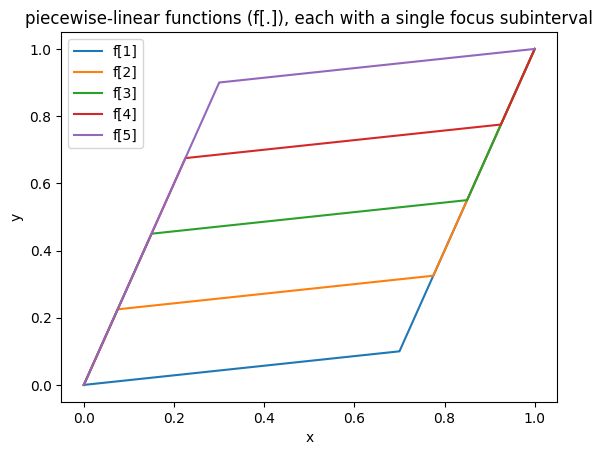

PyObject Text(0.5, 1.0, 'piecewise-linear functions (f[.]), each with a single focus subinterval')

In [3]:
display_t = LinRange(p_lb, p_ub, 5000)

PyPlot.figure(fig_num)
fig_num += 1

for i in eachindex(fs)
    PyPlot.plot(display_t, fs[i].(display_t), label = "f[$(i)]")
end

PyPlot.legend()
PyPlot.xlabel("x")
PyPlot.ylabel("y")
PyPlot.title("piecewise-linear functions (f[.]), each with a single focus subinterval")

`IntervalMonoFuncs.jl` currently does not use an internal optimization code for optimization. The user must supply one externally. This allows flexibility on the type of optimization package, and keeps the complexity of `IntervalMonoFuncs.jl` low. We need to make a function that would run and return a numerical optimization code, and pass the function to `getlogisticprobitparameters()`. 

In [4]:
function runoptimroutine(x_initial, obj_func::Function, grad_func::Function, x_lb, x_ub;
    optim_algorithm = :LN_BOBYQA,
    max_iters = 10000,
    xtol_rel = 1e-12,
    ftol_rel = 1e-12,
    maxtime = Inf)
    
    opt = NLopt.Opt(optim_algorithm, length(x_initial))

    opt.maxeval = max_iters
    opt.lower_bounds = x_lb
    opt.upper_bounds = x_ub
    opt.xtol_rel = xtol_rel
    opt.ftol_rel = ftol_rel
    opt.maxtime = maxtime


    opt.min_objective = (xx, gg)->genericNLoptcostfunc!(xx, gg, obj_func, grad_func)

    # optimize.
    (minf, minx, ret) = NLopt.optimize(opt, x_initial)

    N_evals = opt.numevals

    println("NLopt result:")
    @show N_evals
    @show ret
    @show minf
    println()

    return minx
end

function genericNLoptcostfunc!(x::Vector{T}, df_x, f, df)::T where T <: Real

    if length(df_x) > 0
        df_x[:] = df(x)
    end

    return f(x)
end

runoptimfunc = (pp0, ff, dff, pp_lb, pp_ub)->runoptimroutine(pp0, ff, dff, pp_lb, pp_ub;
    optim_algorithm = :LN_BOBYQA, # a local derivative-free algorithm. For other algorithms in NLopt, see https://nlopt.readthedocs.io/en/latest/NLopt_Algorithms/
    max_iters = 5000,
    xtol_rel = 1e-5,
    ftol_rel = 1e-5,
    maxtime = Inf);

Now we can run the fit routine `getlogisticprobitparameters()`. We can adjust our optimization parameters by changing how we constructed `runoptimfunc`.

In [5]:
### fit the compact sigmoids (composite function of applying probit then logistic functions).
costfuncs, minxs = IntervalMonoFuncs.getlogisticprobitparameters(infos,
    runoptimfunc;
    N_fit_positions = 15,
    a_lb = 0.1,
    a_ub = 0.6,
    b_lb = -5.0,
    b_ub = 5.0,
    a_initial = 0.5,
    b_initial = 0.0)

# This is a family of logistic-probit functions.
qs = collect( tt->IntervalMonoFuncs.evalcompositelogisticprobit(tt, first(minxs[i]), last(minxs[i])) for i in eachindex(minxs) );

NLopt result:
N_evals = 31
ret = :FTOL_REACHED
minf = 0.0001826011706899747

NLopt result:
N_evals = 49
ret = :FTOL_REACHED
minf = 0.0008133195872143126

NLopt result:
N_evals = 34
ret = :FTOL_REACHED
minf = 5.985183037953416e-5

NLopt result:
N_evals = 49
ret = :FTOL_REACHED
minf = 0.0008133195871741431

NLopt result:
N_evals = 31
ret = :FTOL_REACHED
minf = 0.0001826011706900019



Visualize the fitted functions.

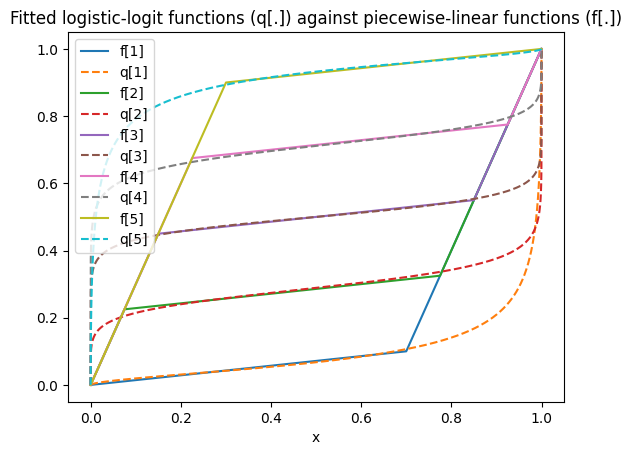

PyObject Text(0.5, 1.0, 'Fitted logistic-logit functions (q[.]) against piecewise-linear functions (f[.])')

In [6]:
PyPlot.figure(fig_num)
fig_num += 1

for l in eachindex(qs)
    PyPlot.plot(display_t, fs[l].(display_t), label = "f[$(l)]")
    PyPlot.plot(display_t, qs[l].(display_t), "--", label = "q[$(l)]")
end

PyPlot.legend()
PyPlot.xlabel("x")
PyPlot.ylabel("")
PyPlot.title("Fitted logistic-logit functions (q[.]) against piecewise-linear functions (f[.])")

Visualize the action of the maps on samples drawn from the uniform distribution on $[0,1]$.

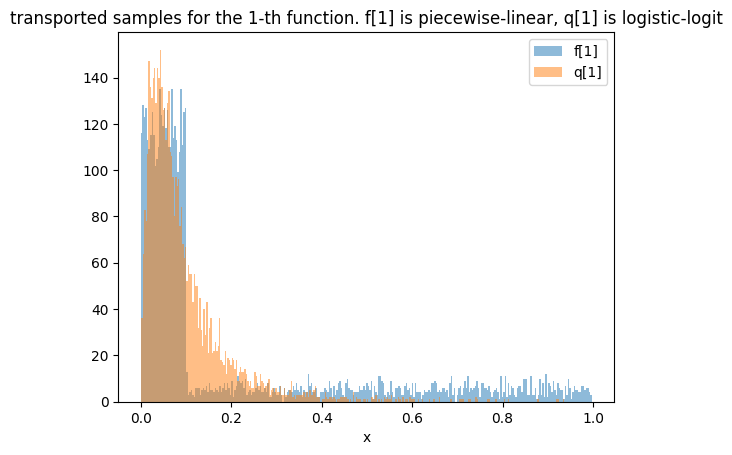

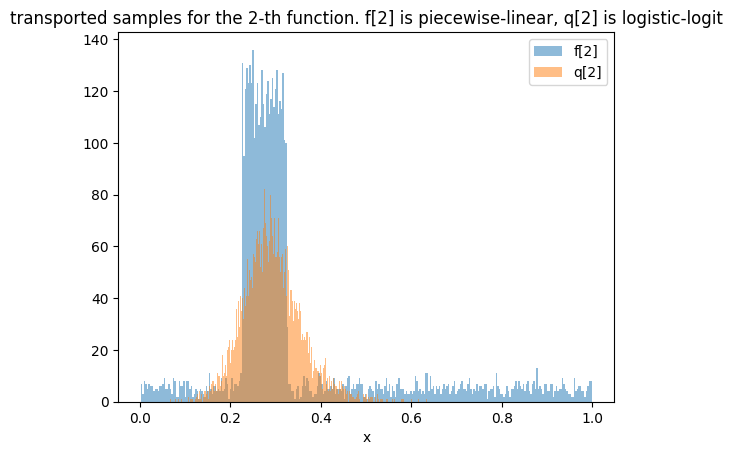

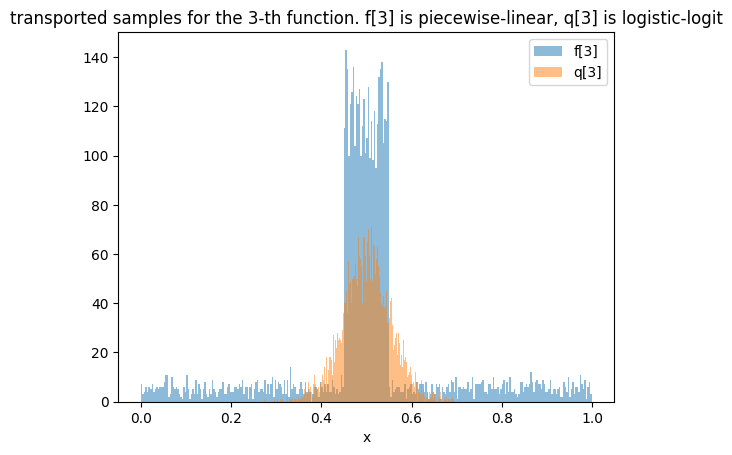

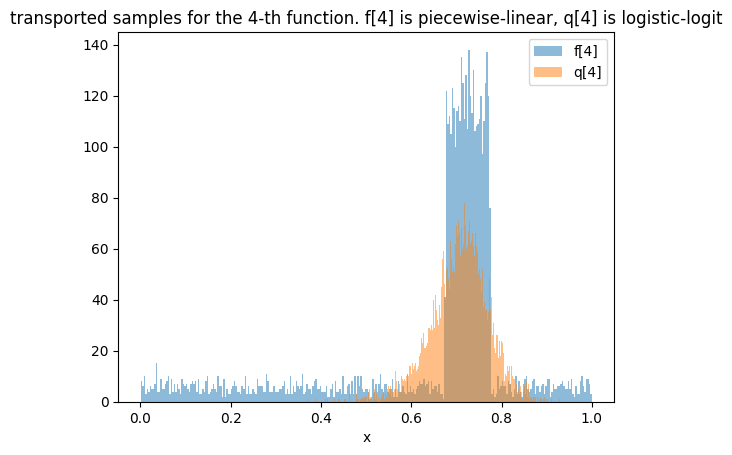

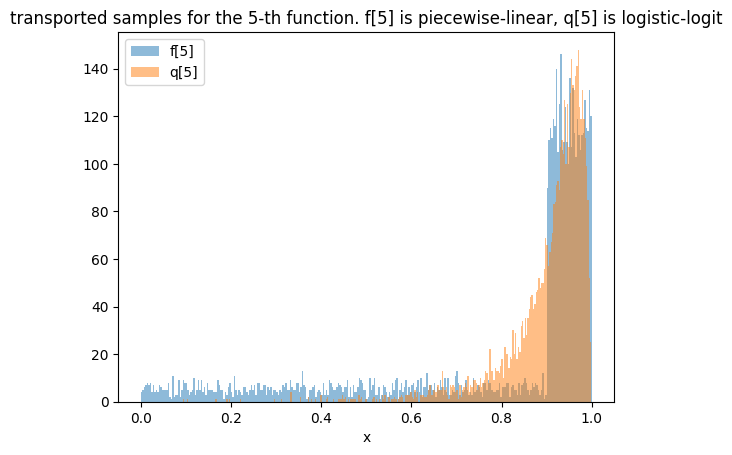

In [7]:
function applytransport(f::Function, N_samples::Int)
    X = rand(N_samples)
    return X, collect( f(X[i]) for i in eachindex(X) )
end

N_bins = 300
N_his_samples = 5000
transparency_alpha = 0.5

for l in eachindex(qs)

    PyPlot.figure(fig_num)
    fig_num += 1

    X, Y = applytransport(fs[l], N_his_samples)
    PyPlot.hist(Y, N_bins, label = "f[$(l)]", alpha = transparency_alpha)

    X, Y = applytransport(qs[l], N_his_samples)
    PyPlot.hist(Y, N_bins, label = "q[$(l)]", alpha = transparency_alpha)

    PyPlot.legend()
    PyPlot.xlabel("x")
    PyPlot.ylabel("")
    PyPlot.title("transported samples for the $l-th function. f[$l] is piecewise-linear, q[$l] is logistic-logit")
end